In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
df = pd.read_csv('test\cnrpt_df3_rm.tsv', sep = '\t', decimal=',', index_col = None)

In [3]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,T
0,3.532957,-2.688169,-7.734620,-1.487700,0.960616,-9.663222,-5.061236,0.595792,3.524385,3.230166,...,4.494999,-1.220376,-2.079228,-7.505519,-5.520562,12.091651,-0.502716,1.286739,-2.521859,0.0
1,2.040346,-2.248233,-8.026994,-2.438789,-1.523883,-8.630269,-4.157207,1.919023,0.978212,4.836547,...,5.102825,-0.817238,-2.349100,-8.304602,-4.240841,12.557021,-0.920269,3.589446,-3.332988,0.0
2,-8.729986,-5.006164,-1.072750,-9.594854,-6.812994,-2.717171,-1.630149,2.201490,-6.800959,1.266206,...,2.937517,-5.894552,0.455392,4.015535,-3.621601,0.141042,-0.732374,-1.677063,-5.160762,1.0
3,-6.983694,-7.234906,-9.038145,-11.879958,-8.281265,-11.062859,-5.681303,3.825669,-6.058642,6.052876,...,8.209838,-6.560162,-1.758553,-4.457586,-7.727757,12.644556,-1.832367,1.845619,-8.462603,0.0
4,-5.808786,-7.671932,-8.786335,-10.624253,-5.501383,-11.300340,-6.311900,1.320805,-4.008851,3.393143,...,9.028193,-6.122593,-1.023667,-4.023775,-8.826133,11.959537,-2.385617,-0.486704,-6.678782,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365244 entries, 0 to 365243
Data columns (total 31 columns):
X0     365244 non-null float64
X1     365244 non-null float64
X2     365244 non-null float64
X3     365244 non-null float64
X4     365244 non-null float64
X5     365244 non-null float64
X6     365244 non-null float64
X7     365244 non-null float64
X8     365244 non-null float64
X9     365244 non-null float64
X10    365244 non-null float64
X11    365244 non-null float64
X12    365244 non-null float64
X13    365244 non-null float64
X14    365244 non-null float64
X15    365244 non-null float64
X16    365244 non-null float64
X17    365244 non-null float64
X18    365244 non-null float64
X19    365244 non-null float64
X20    365244 non-null float64
X21    365244 non-null float64
X22    365244 non-null float64
X23    365244 non-null float64
X24    365244 non-null float64
X25    365244 non-null float64
X26    365244 non-null float64
X27    365244 non-null float64
X28    365244 non-nul

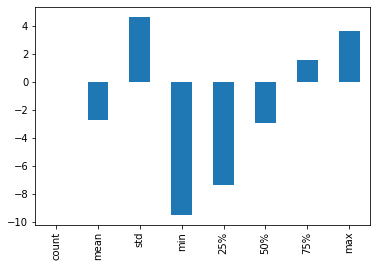

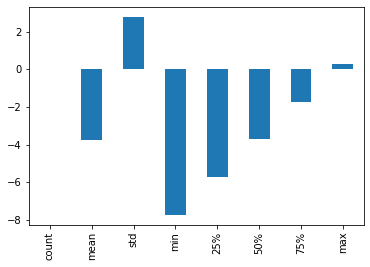

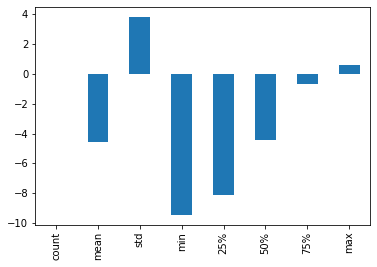

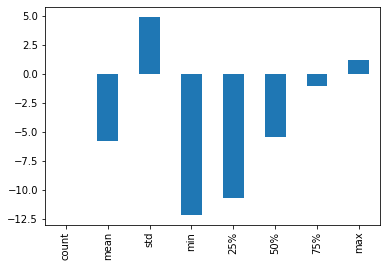

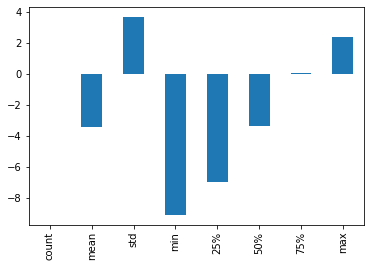

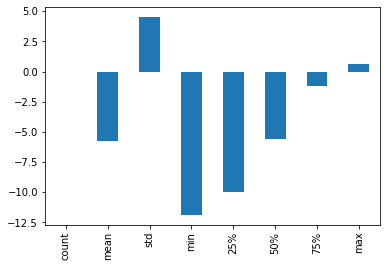

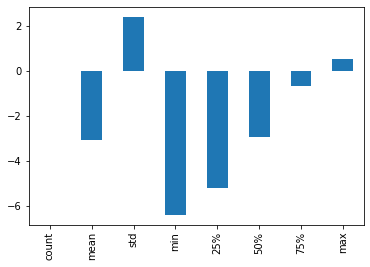

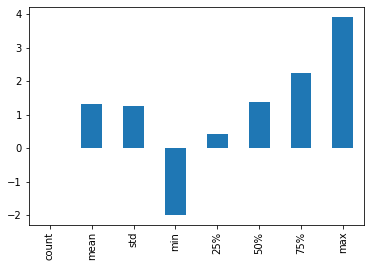

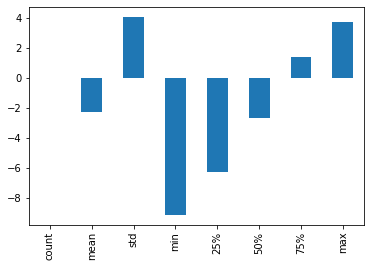

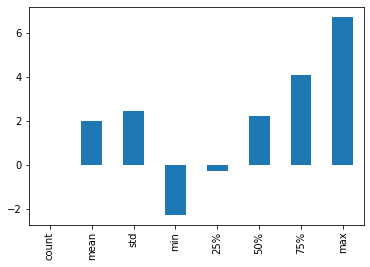

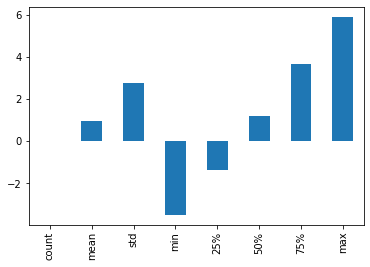

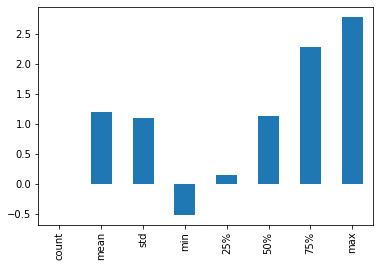

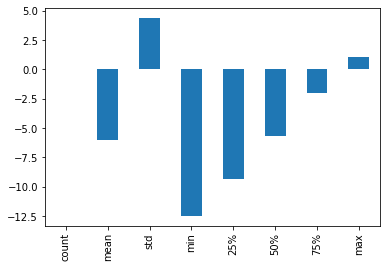

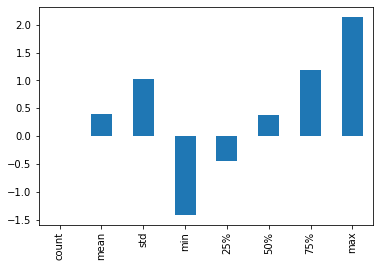

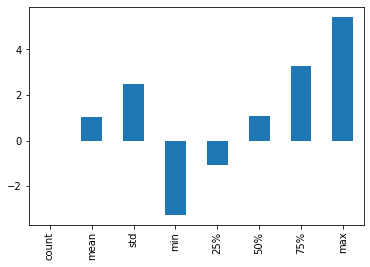

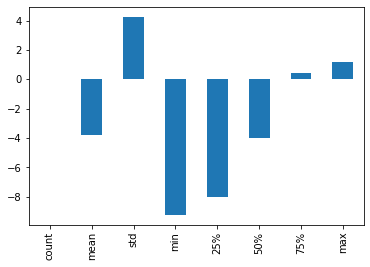

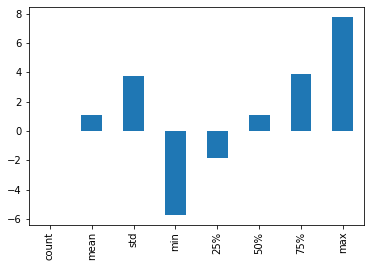

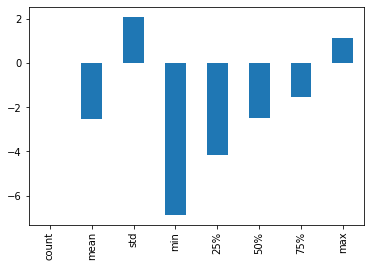

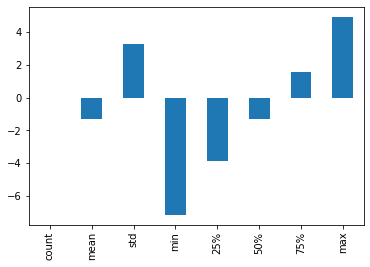

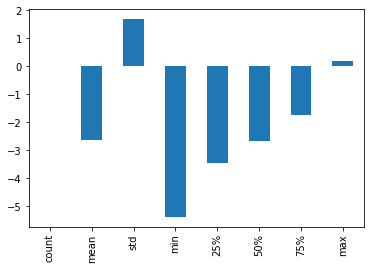

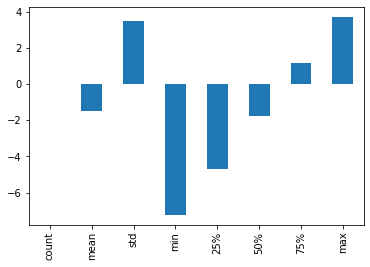

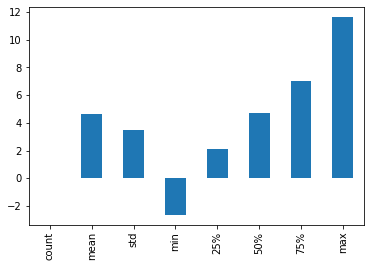

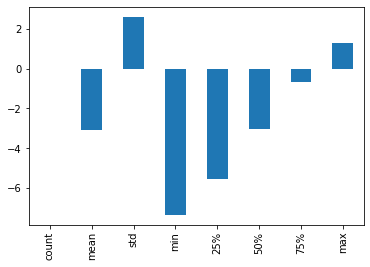

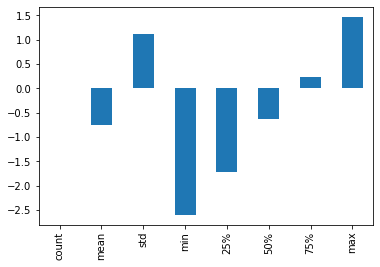

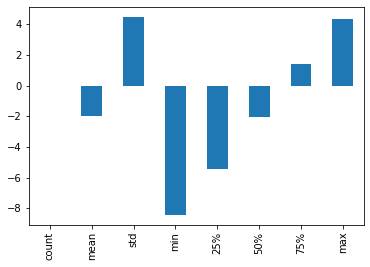

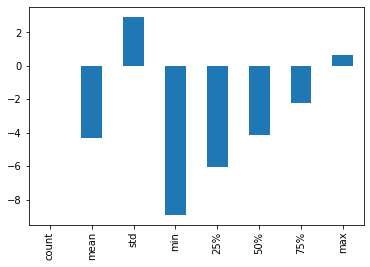

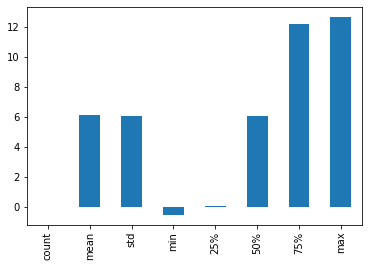

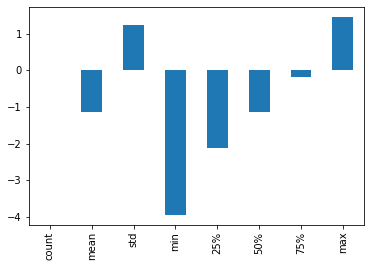

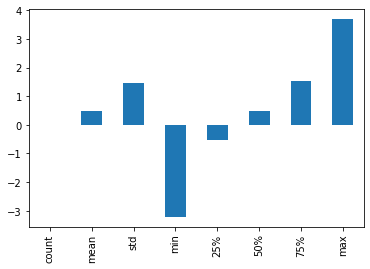

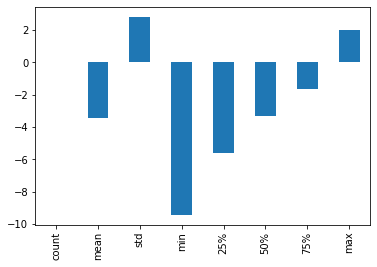

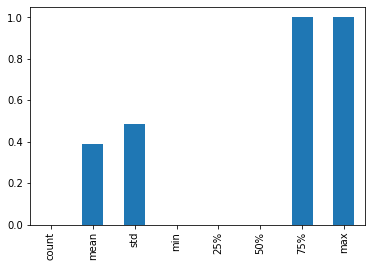

In [5]:
for s in df.columns:
    a =  df[s].describe()
    a.loc['count'] = 0
    a.plot(kind = 'bar')
    plt.show()

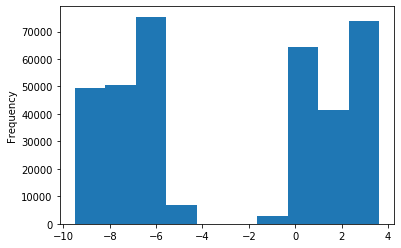

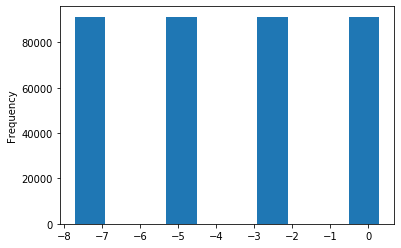

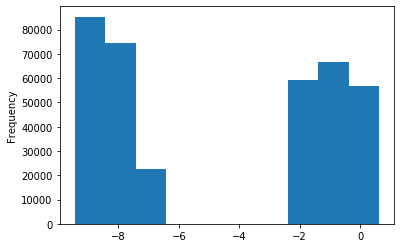

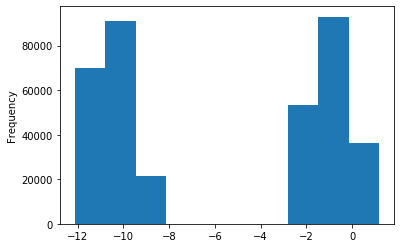

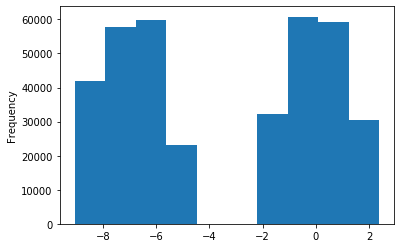

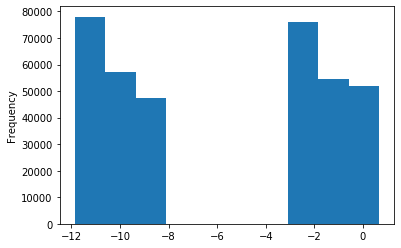

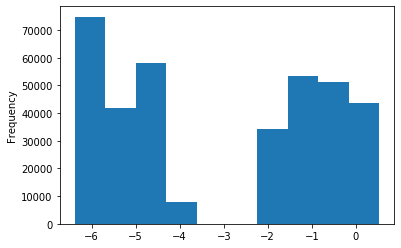

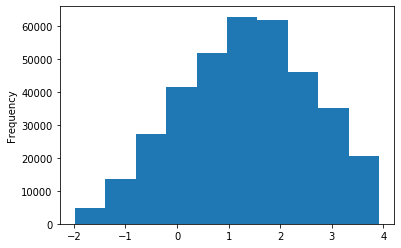

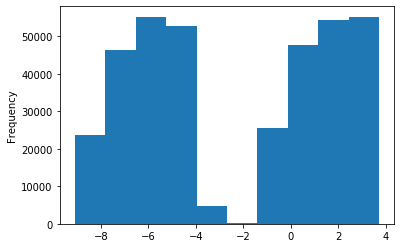

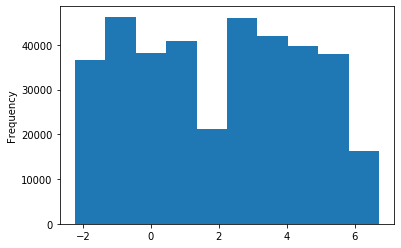

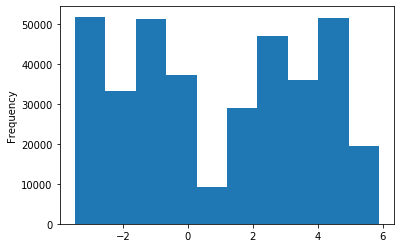

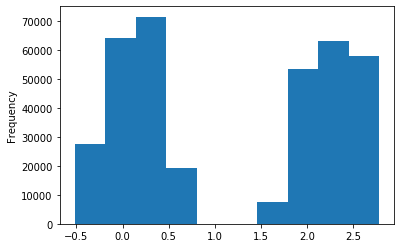

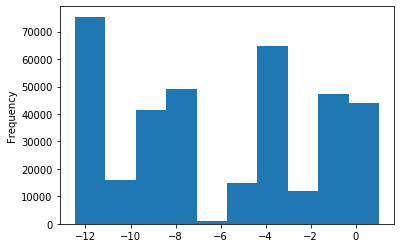

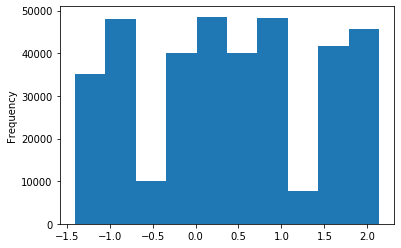

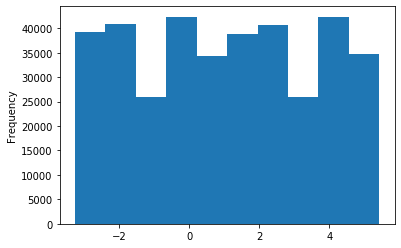

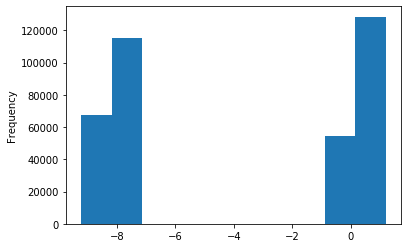

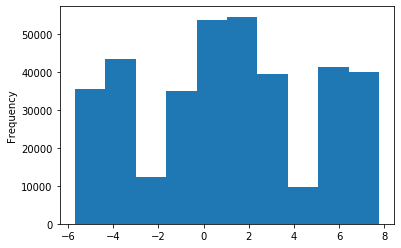

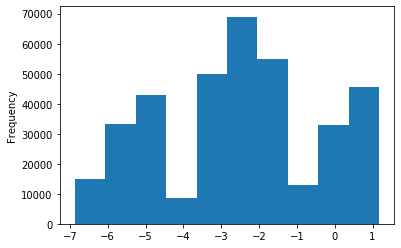

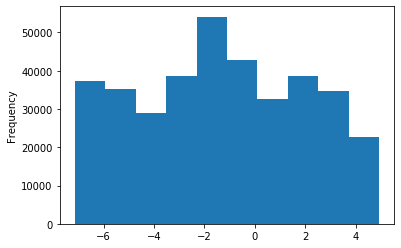

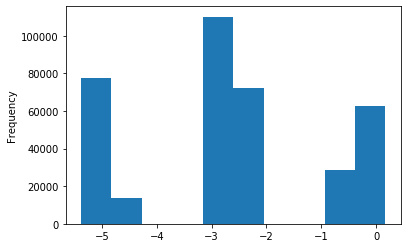

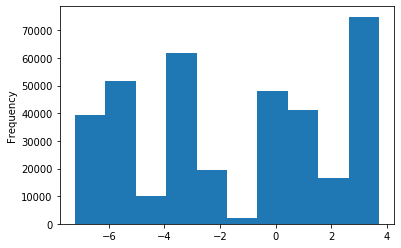

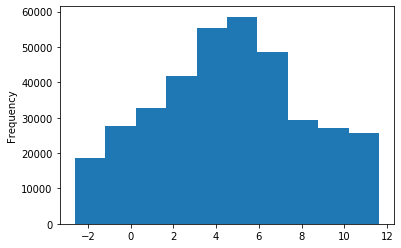

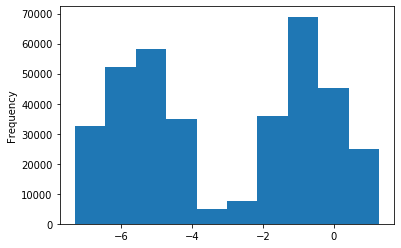

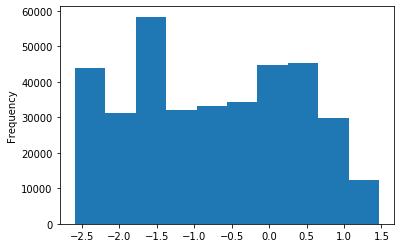

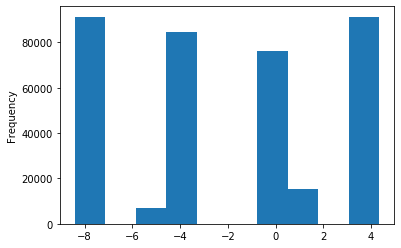

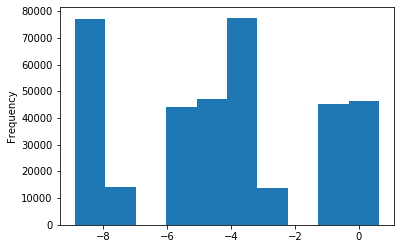

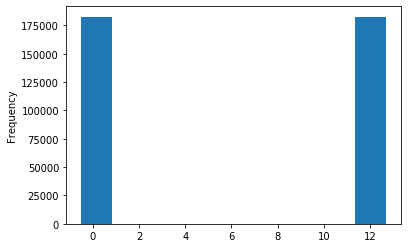

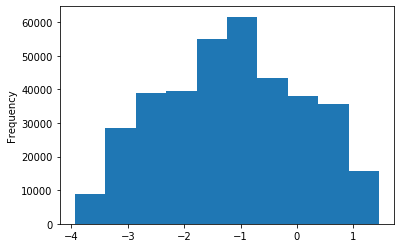

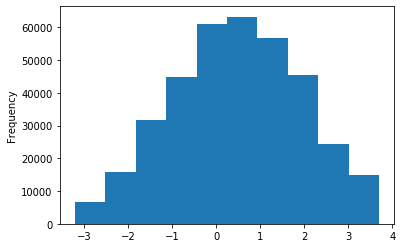

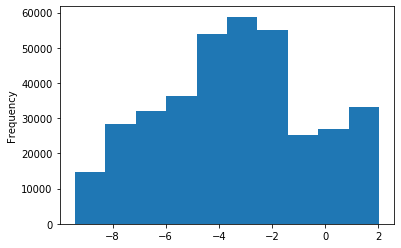

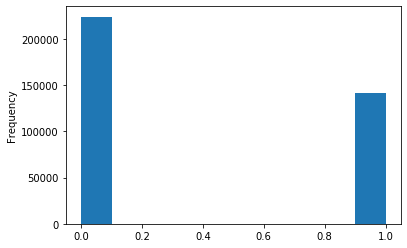

In [6]:
# посмотрим вручную на данные - они выглядят немного странно: у большинства колонок средние значения принимаются крайне редко
for s in df.columns:
    a =  df[s]
    a.plot(kind = 'hist')
    plt.show()

In [7]:
# генератор батчей для линейного классификатора (оптимизация мини-батч градиентным спуском)
def batch_generator(X, y, shuffle=True, batch_size=1):
    ind = np.arange(X.shape[0])
    np.random.shuffle(ind)
    for iter_num in range(X.shape[0] // batch_size):
        ind_b = ind[iter_num * batch_size:(iter_num + 1) * batch_size]
        X_batch = X[ind_b, :]
        y_batch = y[ind_b]
        yield (X_batch, y_batch)

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import preprocessing

# возьмем для начала простую и быструю линейную модель - если выборка линейно разделима, то все будет быстро и хорошо

class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(
            self,
            batch_generator,
            C=1,
            alpha=0.01,
            max_epoch=10,
            model_type='lin_reg',
            batch_size=1,
    ):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.b_size = batch_size
        self.batch_generator = batch_generator
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):

        w0 = self.weights[0, 0]
        w = self.weights[0, 1:].reshape(1, -1)
        a = (w0 + np.dot(X_batch, w.T)).reshape(-1, 1)
        loss = np.dot(a.T - y_batch.T, a - y_batch)
        loss *= 1.0 / self.b_size
        loss += np.dot(w, w.T) / self.C
        return loss

    def calc_loss_grad(self, X_batch, y_batch):

        w0 = self.weights[0, 0]
        w = self.weights[0, 1:].reshape(1, -1)
        a = (w0 + np.dot(X_batch, w.T)).reshape(-1, 1)
        loss_grad_w0 = np.sum(a - y_batch)
        loss_grad_w0 *= 2.0 / self.b_size
        loss_grad_w = np.sum(X_batch * (a - y_batch),
                             axis=0).reshape(1, -1)
        loss_grad_w *= 2.0 / self.b_size
        loss_grad_w += 2.0 / self.C * w
        loss_grad = (loss_grad_w0, loss_grad_w)
        return loss_grad

    def update_weights(self, new_grad):

        (w0_grad, w_grad) = new_grad
        self.weights[0, 0] -= self.alpha * w0_grad
        self.weights[0, 1:] -= self.alpha * w_grad[0, :]

    def fit(self, X, y):

        self.scaler = preprocessing.StandardScaler().fit(X)
        X_st = self.scaler.transform(X)
        self.weights = np.random.randn(1, X.shape[1] + 1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X_st, y, shuffle=True,
                                                       batch_size=self.b_size)
            for (batch_num, new_batch) in \
                    enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1].reshape(-1, 1)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
        return self

    def predict(self, X):

        X_st = self.scaler.transform(X)
        y_hat = np.dot(X_st, self.weights[0, 1:].T) \
                + self.weights[0, 0]
        
        return y_hat

In [9]:
x = np.asarray(df)

In [10]:
x

array([[ 3.53295745, -2.68816883, -7.73461996, ...,  1.28673889,
        -2.52185919,  0.        ],
       [ 2.04034566, -2.24823336, -8.02699392, ...,  3.58944613,
        -3.33298829,  0.        ],
       [-8.729986  , -5.00616375, -1.07274975, ..., -1.67706335,
        -5.16076197,  1.        ],
       ...,
       [-6.74831856, -7.46404635, -8.56848495, ...,  0.06075901,
        -8.77292298,  1.        ],
       [ 2.08954169, -2.4978716 , -7.2357539 , ...,  1.21311646,
        -4.95914293,  1.        ],
       [ 3.070047  , -2.63588785, -7.79324002, ...,  1.50307281,
        -1.78720167,  1.        ]])

In [11]:
X = x[:,0:-1]
X

array([[ 3.53295745, -2.68816883, -7.73461996, ..., -0.50271585,
         1.28673889, -2.52185919],
       [ 2.04034566, -2.24823336, -8.02699392, ..., -0.92026948,
         3.58944613, -3.33298829],
       [-8.729986  , -5.00616375, -1.07274975, ..., -0.73237417,
        -1.67706335, -5.16076197],
       ...,
       [-6.74831856, -7.46404635, -8.56848495, ..., -1.24388918,
         0.06075901, -8.77292298],
       [ 2.08954169, -2.4978716 , -7.2357539 , ...,  0.7148255 ,
         1.21311646, -4.95914293],
       [ 3.070047  , -2.63588785, -7.79324002, ..., -1.38586722,
         1.50307281, -1.78720167]])

In [12]:
target = x[:,-1]
target = np.asarray(target, dtype = int)
target

array([0, 0, 1, ..., 1, 1, 1])

In [13]:
# будем смотреть качество на кросс-валидации
from sklearn.model_selection import KFold
kfold = KFold(3,True)


In [14]:
# в качестве метрики возьмем f1 score
from sklearn.metrics import f1_score

for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    th = 0.2
    alpha = 0.005
    C = 50
    batch_size = 500
    max_epoch = 20
    model = MySGDClassifier(batch_generator, alpha=alpha,
                            max_epoch=max_epoch, C=C,
                            model_type='lin_reg',
                            batch_size=batch_size)
    model.fit(X_train, y_train)
    a = model.predict(X_test)
    a[np.where(a >= th)] = 1
    a[np.where(a < th)] = 0
    print(f1_score(y_test, a))

TRAIN: [     0      1      2 ... 365238 365239 365242] TEST: [     3      6      7 ... 365240 365241 365243]
0.5581287934863064
TRAIN: [     0      3      6 ... 365240 365241 365243] TEST: [     1      2      4 ... 365238 365239 365242]
0.5583422143280047
TRAIN: [     1      2      3 ... 365241 365242 365243] TEST: [     0      8     15 ... 365221 365222 365235]
0.5589309281584196


In [15]:
# линейная модель работает плохо, поэтому будем строить дерево

In [16]:
class MyDecisionTreeClassifier:

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.criterion = criterion
        self.tree = dict()
        

    def __div_samples(self, x, y, feature_id, threshold):
        
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
       
        max_f_id = 0
        max_threshold = 0
        if self.criterion == 'gini':
            Qmax = np.Inf
            un = np.unique(y)
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in un])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                left = np.sum(classes_left[:-1,:].T[:,-1::-1]*np.cumsum(classes_left[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right = np.sum(classes_right[:-1,:].T[:,-1::-1]*np.cumsum(classes_right[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right_total[-1] = 1
                gini = left/left_total + right/right_total
                min_ths_ind = np.argmin(gini)
                Q = gini[min_ths_ind]
                if Qmax > Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id                
                   
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
        
        un = np.unique(y).size
        if un == 1:
            class_pred = y[0]
            class_proba = 1
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            counts = np.bincount(y, minlength = un)
            class_pred = np.argmax(counts)
            class_proba = counts[class_pred]/(y.shape[0])
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if xl.shape[0] and xr.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            else:
                counts = np.bincount(y, minlength = un)
                class_pred = np.argmax(counts)
                class_proba = counts[class_pred]/(y.shape[0])
                self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]      
        
    
    def fit(self, x, y):
   
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        
        node = self.tree[node_id]
        # print("node", node)
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        
        return np.array([self.__predict_class(x, 0) for x in X])

In [17]:
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    model = MyDecisionTreeClassifier(min_samples_split=2, max_depth=35, criterion='gini')
    model.fit(X_train, y_train)
    a = model.predict(X_test)
    print(f1_score(y_test, a))

TRAIN: [     0      1      3 ... 365237 365238 365239] TEST: [     2      5     10 ... 365241 365242 365243]
0.8572437406377061
TRAIN: [     0      1      2 ... 365241 365242 365243] TEST: [     3      4      6 ... 365237 365238 365239]
0.8571397830951972
TRAIN: [     2      3      4 ... 365241 365242 365243] TEST: [     0      1     14 ... 365232 365233 365236]
0.8641377745605411


In [18]:
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    model = MyDecisionTreeClassifier(min_samples_split=2, max_depth=50, criterion='gini')
    model.fit(X_train, y_train)
    a = model.predict(X_test)
    print(f1_score(y_test, a))

TRAIN: [     1      2      3 ... 365240 365241 365243] TEST: [     0      4      6 ... 365225 365227 365242]
0.8580848840090939
TRAIN: [     0      2      3 ... 365239 365242 365243] TEST: [     1     11     13 ... 365238 365240 365241]
0.8671183242930343
TRAIN: [     0      1      4 ... 365240 365241 365242] TEST: [     2      3      5 ... 365237 365239 365243]
0.8678670300663133


In [19]:
# одно дерево - хорошо, а много деревьев еще лучше, поэтому построим рандом форест
# для этого нужно добавить в алгоритм дерева рандомизацию признаков

class MyDecisionTreeClassifier:
   
    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', n_features = None):
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.criterion = criterion
        self.tree = dict()
        self.n_features = n_features
        

    def __div_samples(self, x, y, feature_id, threshold):
        
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
       
        max_f_id = 0
        max_threshold = 0
        if self.criterion == 'gini':
            Qmax = np.Inf
            un = np.unique(y)
            if self.n_features is None:
                features = range(x.shape[1])
            else:
                features = np.sort(np.random.choice(x.shape[1],self.n_features , False))
            for feature_id in features:
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in un])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                left = np.sum(classes_left[:-1,:].T[:,-1::-1] * np.cumsum(classes_left[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right = np.sum(classes_right[:-1,:].T[:,-1::-1] * np.cumsum(classes_right[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right_total[-1] = 1
                gini = left/left_total + right/right_total
                min_ths_ind = np.argmin(gini)
                Q = gini[min_ths_ind]
                if Qmax > Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id                
                   
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
        
        un = np.unique(y).size
        if un == 1:
            class_pred = y[0]
            class_proba = 1
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            counts = np.bincount(y, minlength = un)
            class_pred = np.argmax(counts)
            class_proba = counts[class_pred]/(y.shape[0])
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if xl.shape[0] and xr.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            else:
                counts = np.bincount(y, minlength = un)
                class_pred = np.argmax(counts)
                class_proba = counts[class_pred]/(y.shape[0])
                self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]      
        
    
    def fit(self, x, y):
   
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        
        node = self.tree[node_id]
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        
        return np.array([self.__predict_class(x, 0) for x in X])


In [20]:
from sklearn.utils import resample

class BaggingClassifier():
    
    def __init__(self, base_model_class, n_base_models, **base_model_params):
        self.n_base_models = n_base_models
        self.base_models = [self._create_model_(base_model_class, **base_model_params) 
                            for _ in range(self.n_base_models)]
    
    def _create_model_(self, base_model_class, **base_model_params):
        return base_model_class(**base_model_params)
    
    def _create_bagging_subsample_(self, X, y):
        
        X_bagging, y_bagging = resample(X, y)
        return X_bagging, y_bagging
        
    def fit(self, X, y):
        for base_model in self.base_models:
            X_bagging, y_bagging = self._create_bagging_subsample_(X, y)
            base_model.fit(X_bagging, y_bagging)
    
    def predict(self, X):
        
        base_models_predictions = np.asarray([base_model.predict(X) for base_model in self.base_models],
                                             dtype=np.int).transpose(1, 0)  
        self.base_models_predictions = base_models_predictions
        result = np.argmax(np.asarray([np.bincount(base_models_predictions[k,:],
                                                   minlength =  np.unique(base_models_predictions)[-1] + 1) 
                                       for k in range(base_models_predictions.shape[0])]),axis = 1)
        return np.asarray(result)

In [21]:
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    model = BaggingClassifier(MyDecisionTreeClassifier, 15, max_depth = 25, criterion = 'gini', n_features = 25)
    model.fit(X_train, y_train)
    a = model.predict(X_test)
    print(f1_score(y_test, a))

TRAIN: [     0      1      3 ... 365240 365241 365243] TEST: [     2      4      5 ... 365237 365238 365242]
0.9354096110852868
TRAIN: [     0      1      2 ... 365240 365242 365243] TEST: [     3      8     11 ... 365232 365234 365241]
0.9354598333945036
TRAIN: [     2      3      4 ... 365238 365241 365242] TEST: [     0      1      6 ... 365239 365240 365243]
0.9352548408635656


In [22]:
# работает очень-очень долго, но качество неплохое

In [23]:
df = pd.read_csv('test\mx2.tsv', sep = '\t', decimal=',', index_col = None)

In [24]:
from sklearn.base import RegressorMixin

class MySGDRegressor(BaseEstimator, RegressorMixin):

    def __init__(
            self,
            batch_generator,
            C=1,
            alpha=0.01,
            max_epoch=10,
            model_type='lin_reg',
            batch_size=1,
    ):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.b_size = batch_size
        self.batch_generator = batch_generator
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):

        w0 = self.weights[0, 0]
        w = self.weights[0, 1:].reshape(1, -1)
        a = (w0 + np.dot(X_batch, w.T)).reshape(-1, 1)
        loss = np.dot(a.T - y_batch.T, a - y_batch)
        loss *= 1.0 / self.b_size
        loss += np.dot(w, w.T) / self.C
        return loss

    def calc_loss_grad(self, X_batch, y_batch):

        w0 = self.weights[0, 0]
        w = self.weights[0, 1:].reshape(1, -1)
        a = (w0 + np.dot(X_batch, w.T)).reshape(-1, 1)
        loss_grad_w0 = np.sum(a - y_batch)
        loss_grad_w0 *= 2.0 / self.b_size
        loss_grad_w = np.sum(X_batch * (a - y_batch),
                             axis=0).reshape(1, -1)
        loss_grad_w *= 2.0 / self.b_size
        loss_grad_w += 2.0 / self.C * w
        loss_grad = (loss_grad_w0, loss_grad_w)
        return loss_grad

    def update_weights(self, new_grad):

        (w0_grad, w_grad) = new_grad
        self.weights[0, 0] -= self.alpha * w0_grad
        self.weights[0, 1:] -= self.alpha * w_grad[0, :]

    def fit(self, X, y):

        self.scaler = preprocessing.StandardScaler().fit(X)
        X_st = self.scaler.transform(X)
        self.weights = np.random.randn(1, X.shape[1] + 1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X_st, y, shuffle=True,
                                                       batch_size=self.b_size)
            for (batch_num, new_batch) in \
                    enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1].reshape(-1, 1)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
               
        return self

    def predict(self, X):

        X_st = self.scaler.transform(X)
        y_hat = np.dot(X_st, self.weights[0, 1:].T) + self.weights[0, 0]
        
        return y_hat

In [25]:
x = np.asarray(df)
X = x[:,0:-1]
target = x[:,-1]
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    alpha = 0.005
    C = 50
    batch_size = 500
    max_epoch = 20
    model = MySGDRegressor(batch_generator, alpha=alpha,
                            max_epoch=max_epoch, C=C,
                            batch_size=batch_size)
    model.fit(X_train, y_train)
    print(model.score(X_test,y_test))

TRAIN: [    0     1     2 ... 49995 49997 49999] TEST: [    3     6    10 ... 49993 49996 49998]
-0.006821129029103146
TRAIN: [    0     3     4 ... 49997 49998 49999] TEST: [    1     2     5 ... 49987 49992 49994]
-0.005887976240204873
TRAIN: [    1     2     3 ... 49994 49996 49998] TEST: [    0     4     8 ... 49995 49997 49999]
-0.005438254530606201


In [26]:
# линейная модель справляется очень плохо, пробуем дерево

In [27]:
class MyDecisionTreeRegressor(RegressorMixin):

    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = dict()
        

    def __div_samples(self, x, y, feature_id, threshold):
       
        left_mask = x[:, feature_id] < threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
       
        max_f_id = 0
        max_threshold = 0
        Fmin = np.Inf
        # медленный вариант, можно ускорить если по умному считать разброс
        for feature_id in range(x.shape[1]):
            ind = np.argsort(x[:,feature_id])
            x_ = x[ind]
            y_ = y[ind]
            for i in range(1, x.shape[0]):
                F = (i)*np.std(y_[0:i])+(x.shape[0]-i)*np.std(y_[i:])
                if Fmin > F:
                    Fmin = F
                    index = i
                    max_threshold = x_[index, feature_id]
                    max_f_id = feature_id 
                                                  
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
       
        min_std = 0.05
        std = np.std(y)
        if std<=min_std:
            pred = np.mean(y)
            self.tree[node_id] = ['LEAF_TYPE', pred]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            pred = np.mean(y)
            self.tree[node_id] = ['LEAF_TYPE', pred]
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if xl.shape[0] and xr.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            else:
                pred = np.mean(y)
                self.tree[node_id] = ['LEAF_TYPE', pred]
        
    
    def fit(self, x, y):
        
        self.__fit_node(x, y, 0, 0) 

    def __predict_value(self, x, node_id):
       
        node = self.tree[node_id]
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] < threshold:
                return self.__predict_value(x, 2 * node_id + 1)
            else:
                return self.__predict_value(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        
        return np.array([self.__predict_value(x, 0) for x in X])
    

In [28]:
x = np.asarray(df)
X = x[:,0:-1]
target = x[:,-1]
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]  
    model = MyDecisionTreeRegressor(max_depth=15)
    model.fit(X_train, y_train)
    print(model.score(X_test,y_test))

TRAIN: [    2     4     5 ... 49996 49997 49999] TEST: [    0     1     3 ... 49985 49987 49998]
0.6260779911241497
TRAIN: [    0     1     3 ... 49994 49996 49998] TEST: [    2     6     8 ... 49995 49997 49999]
0.6220109725219475
TRAIN: [    0     1     2 ... 49997 49998 49999] TEST: [    4     5     7 ... 49992 49994 49996]
0.6181977508500631
